# 201600779 김영민

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt
import os

In [3]:
os.chdir('/content/drive/MyDrive/GAN_basic')

In [4]:
# 데이터셋 클래스

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # 이미지 목표(레이블)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 0-255의 이미지를 0-1로 정규화
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [5]:
mnist_dataset = MnistDataset('mnist_train.csv')

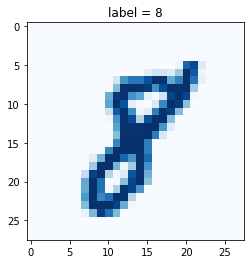

In [6]:
# 이미지 확인

mnist_dataset.plot_image(17)

In [7]:
# 동일한 임의 데이터를 생성하기위한 함수

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [8]:
# 분류기 클래스

class Discriminator(nn.Module):
    
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # 손실함수 설정
        self.loss_function = nn.MSELoss()

        # 옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망의 결과 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기 초기화, 역전파 실행, 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [9]:
%%time
# 판별기가 임의의 노이즈로부터 실제 데이터를 구별할수 있는지 확인

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 2min 8s, sys: 1.43 s, total: 2min 10s
Wall time: 2min 10s


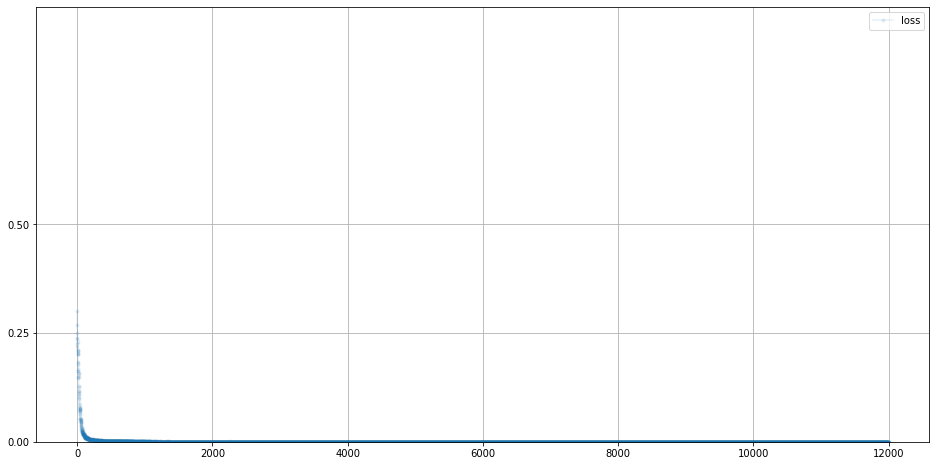

In [10]:
# 판별기 손실 플롯

D.plot_progress()

In [11]:
# 가짜와 진짜를 판별할수 있는지 판별기 직접 구동

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random(784) ).item() )
  pass

0.9965954422950745
0.9968066215515137
0.9958357810974121
0.9950889945030212
0.005173895042389631
0.00468506570905447
0.004637985490262508
0.006012799683958292


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # SGD 옵티마이저 생성
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기에 값 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

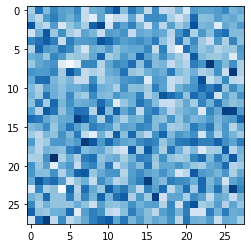

In [13]:
# 생성기의 출력이 올바른 타입과 형태를 지니고 있는지 확인

G = Generator()

output = G.forward(generate_random(1))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [14]:
%%time 

# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련

for label, image_data_tensor, target_tensor in mnist_dataset:

    # 참일 경우 판별기 훈련
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 34s, sys: 2.85 s, total: 3min 37s
Wall time: 3min 36s


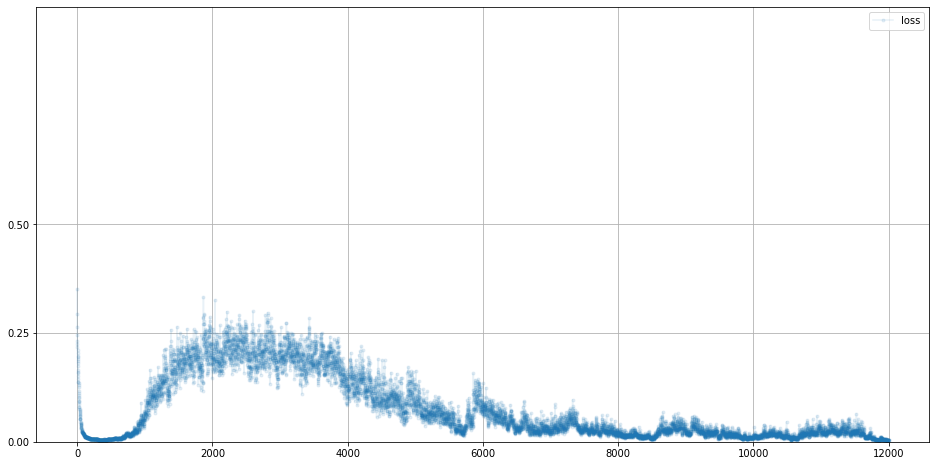

In [15]:
# 판별기 오차 플롯

D.plot_progress()

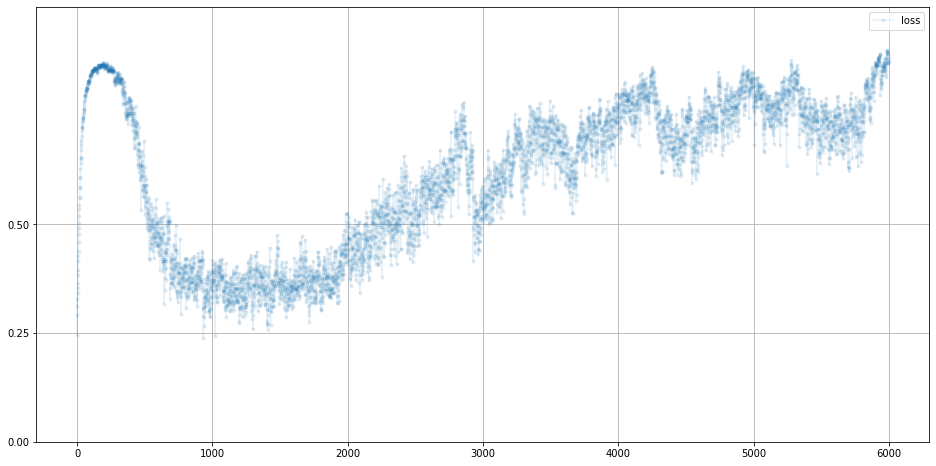

In [16]:
G.plot_progress()

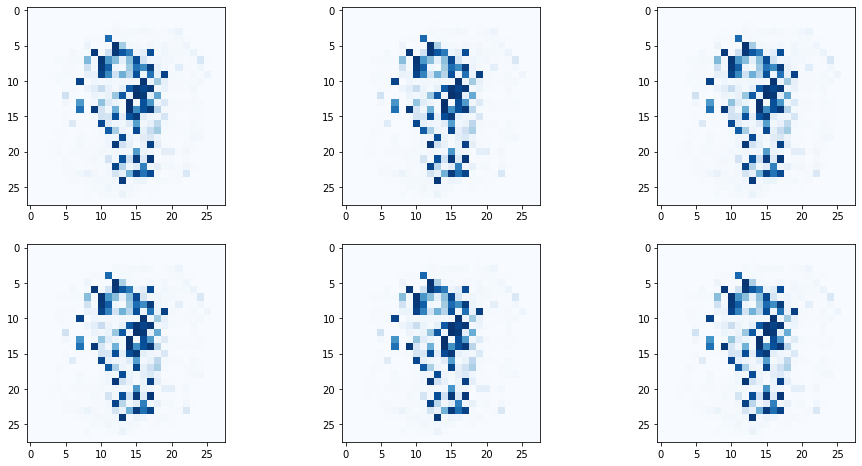

In [17]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [18]:
# 동일한 임의 데이터를 생성하기위한 함수

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [19]:
# 분류기 클래스

class Discriminator(nn.Module):
    
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # 손실함수 설정
        self.loss_function = nn.BCELoss()

        # 옵티마이저 설정
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망의 결과 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기 초기화, 역전파 실행, 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [20]:
%%time
# 판별기가 임의의 노이즈로부터 실제 데이터를 구별할수 있는지 확인

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 11s, sys: 4.06 s, total: 4min 15s
Wall time: 4min 15s


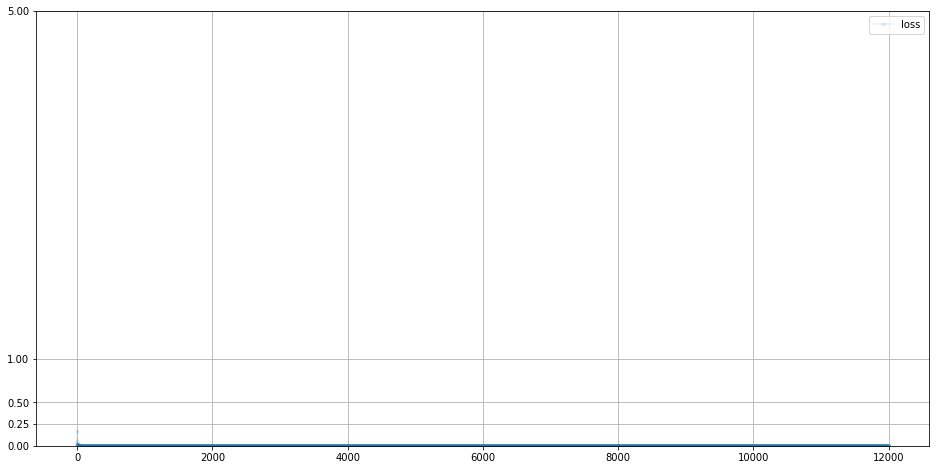

In [21]:
D.plot_progress()

In [22]:
# 가짜와 진짜를 판별할수 있는지 판별기 직접 구동

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784) ).item() )
  pass

1.0
1.0
1.0
1.0
8.71640173233379e-12
1.0950013465405029e-11
9.248347747348173e-12
9.745163877250551e-12


In [23]:
class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기에 값 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [24]:
%%time 

# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # 판별기와 생성기 훈련

  for label, image_data_tensor, target_tensor in mnist_dataset:
    # 참일 경우 판별기 훈련
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 27min 5s, sys: 24.2 s, total: 27min 30s
Wall time: 27min 25s


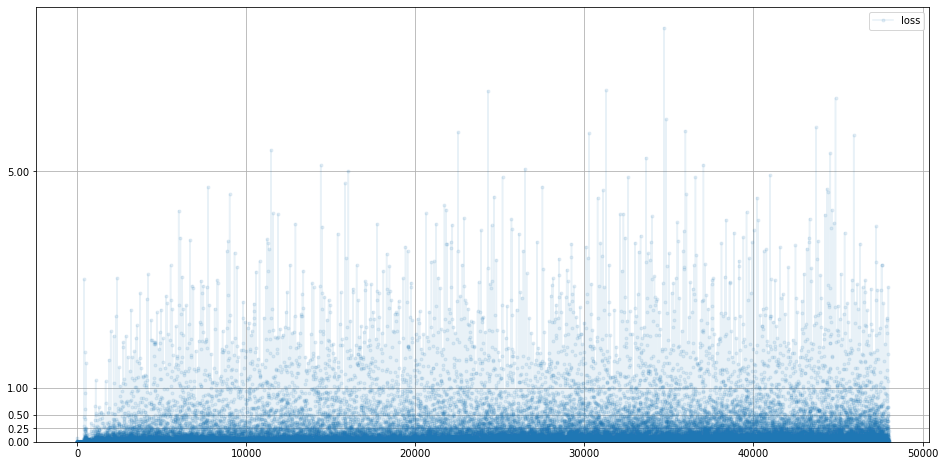

In [25]:
D.plot_progress()

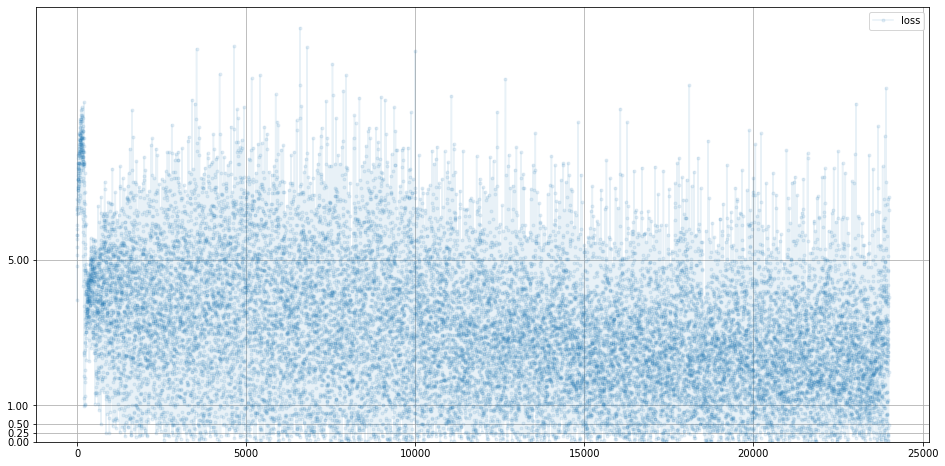

In [26]:
# 생성기 오차 플롯

G.plot_progress()

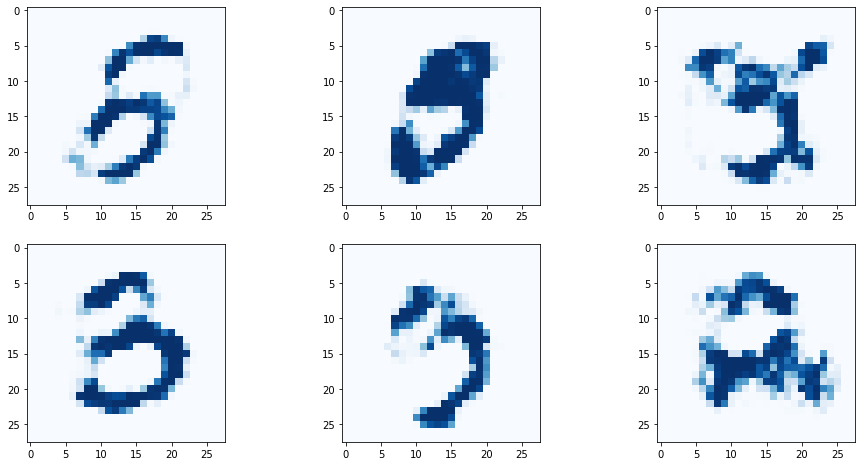

In [27]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [ ]:
# seed 실험

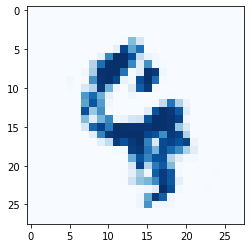

In [28]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

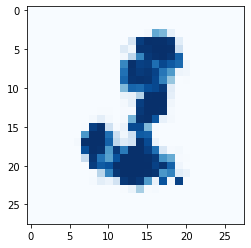

In [29]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

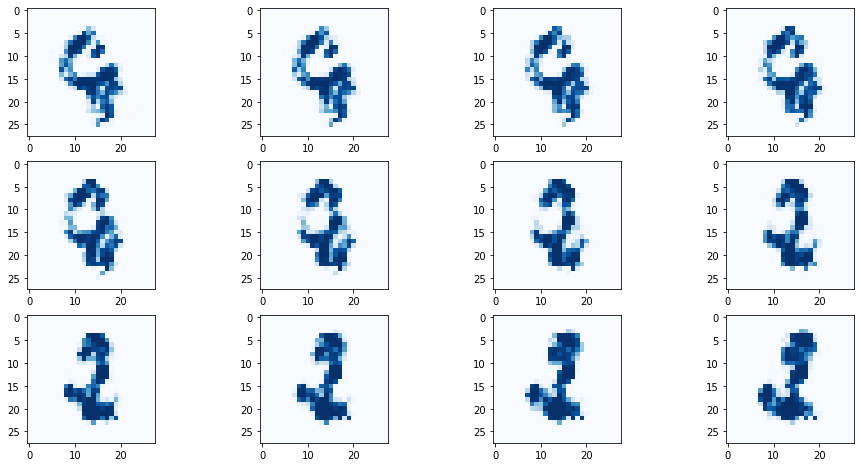

In [30]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

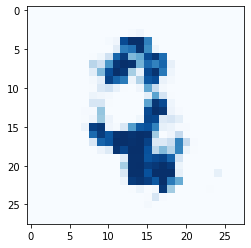

In [31]:
# 시드 합

seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

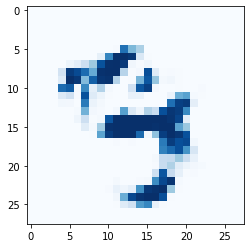

In [32]:
# 시드 차이

seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

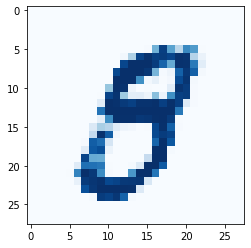

In [33]:
# 시드 차이

seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

## 201600779 김영민